## Описание задачи
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.Игры мы реализуем по всему миру.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й.

## Предобработка данных

Импортируем основные библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from matplotlib.ticker import FormatStrFormatter


In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
display(data.head())
display(data.info())
display(data.duplicated().sum())
display(data.describe())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

0

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Опишем проблемы в данных

1)Название столбцов нужно привести к нижнему регистру

2)В данных есть пропуски в оценках, пропущены две игры и два жанра(можно написать там "NO"). В годах пропуски, нужно заполнить нулями, тип поменять на целочисленный(мало пропусков в годах, мы не сильно потеряем заполнив просто нулями) Очевидных дубликатов нет.

3)Продажи можно умножить на тысячу и превести в целочисленный тип для удобства.

4)В продажах в методи describe видно,что от 75% до 100% сильный скачок. Я думаю что это не ошибка, а просто очень популярные игры среди кучи других непопулярных. 

5)Относительно заполнений пропусков, не вижу чем бы их можно было заполнить, пользовательскую и другие оценки не угадаешь(поэтому ставить среднее и медиану точно неправильно). Рейтинг где то можно заполнить опираясь на жанр игры.

In [4]:
#1
data = data.rename(str.lower, axis='columns')#переименования столбцов нижний регистр

Name — название игры

Platform — платформа

Year_of_Release — год выпуска

Genre — жанр игры

NA_sales — продажи в Северной Америке (миллионы проданных копий)

EU_sales — продажи в Европе (миллионы проданных копий)

JP_sales — продажи в Японии (миллионы проданных копий)

Other_sales — продажи в других странах (миллионы проданных копий)

Critic_Score — оценка критиков (максимум 100)

User_Score — оценка пользователей (максимум 10)

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг 
компьютерных игр и присваивает им подходящую возрастную категорию.

In [5]:
data = data.dropna(subset = ['genre','year_of_release'])# удалим строки в которых нет данных по годам и жанр, их немного и в дальнейшем без знания года они не помогут нам для анализа
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [6]:
display(data['platform'].unique())
display(data['user_score'].unique())# в пользовательских оценках есть tbd это может помешать в дальнейшем анализе, нужно поменять на другое значение(-1), т.к ноль там встречается-скорее всего игра так плоха, что там ноль
display(data['rating'].unique())
display(data['critic_score'].unique())
display(data['genre'].unique())


array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

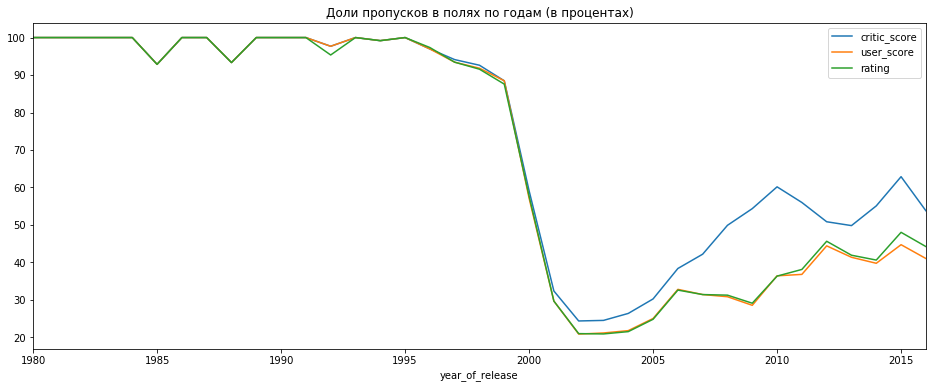

In [7]:
data[data['year_of_release'] > 0].groupby('year_of_release')[['critic_score', 'user_score', 'rating']] \
        .agg(lambda x: x.isna().mean()).mul(100) \
        .plot(title='Доли пропусков в полях по годам (в процентах)', figsize=(16, 6));

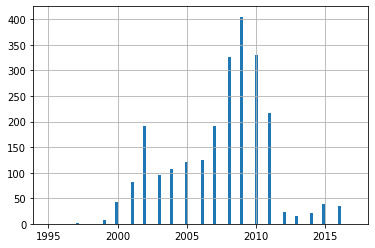

In [8]:
data[data['user_score'] == 'tbd']['year_of_release'].hist(bins =100,range = (1995, 2017))

# поменяем tbd на nan.на целочисленный менять не буду, так как оценки пользователей не всегда равны 6,7 и т.д.
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [9]:

data['na_sales'] = data['na_sales'].astype('int64')
data['eu_sales'] = data['eu_sales'].astype('int64')
data['other_sales'] = data['other_sales'].astype('int64')
data['jp_sales'] = data['jp_sales'].astype('int64')
data['year_of_release'] = data['year_of_release'].astype('int64')
data['user_score'] = data['user_score'].astype('float')

In [10]:
#в тысячах более нагялдно,чем в миллионах(все что у нуля "замывается")
data['na_sales'] = data['na_sales']*1000
data['eu_sales'] = data['eu_sales']*1000
data['other_sales'] = data['other_sales']*1000
data['jp_sales'] = data['jp_sales']*1000

In [11]:
#5 создадим 2 копию, где будут данные с рейтингами,чтобы потом на основании этой таблицы заполнить данные 
data2 = data.copy()
data2.dropna(subset = ['rating'],inplace = True)
data2 = data2[['genre','rating']].reset_index(drop = True)
data2['rating2'] = data2['rating']
data2_pivot = data2.pivot_table(index = ['genre','rating'],aggfunc = 'count')
data2_pivot
#рейтинги сильно разбросаны по жанру, мое предположение что один какой то рейтинг может быть привязан к жанру не оправдались, пропуски заполнять в жанре не буду

rating2
genre        rating         
Action       AO            1
             E           410
             E10+        468
             EC            1
             M           596
             T           670
Adventure    E           159
             E10+         67
             EC            2
             M            98
             T           114
Fighting     E             8
             E10+         19
             M            48
             T           357
Misc         E           449
             E10+        166
             EC            5
             K-A           1
             M            13
             T           228
Platform     E           354
             E10+        141
             M             3
             T            63
Puzzle       E           284
             E10+         42
             T            10
Racing       E           576
             E10+         95
             M            18
             T           167
Role-Playing E            83
             E10+        111
             M           161
             T           415
Shooter      E            47
             E10+         56
             M           553
             T           340
Simulation   E           321
             E10+         47
             M             5
             T           186
Sports       E          1162
             E10+        105
             M            16
             T           195
Strategy     E            68
             E10+         76
             K-A           2
             M            25
             RP            1
             T           160

К пропускам в данных могли привести,то, что игры в базе есть достаточно старые и непопулярные,соответсвенно для одинх рейтинги могли еще не остсавлять, а для непопулярных даже в современном мире могли не ставить оценки.

In [12]:
data['world_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,Wii Sports,Wii,2006,Sports,41000,28000,3000,8000,76.0,8.0,E,80000
1,Super Mario Bros.,NES,1985,Platform,29000,3000,6000,0,NaN,NaN,NaN,38000
2,Mario Kart Wii,Wii,2008,Racing,15000,12000,3000,3000,82.0,8.3,E,33000
3,Wii Sports Resort,Wii,2009,Sports,15000,10000,3000,2000,80.0,8.0,E,30000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11000,8000,10000,1000,NaN,NaN,NaN,30000


## Исследовательский анализ данных

**Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?**


In [13]:

display(data['year_of_release'].value_counts())#можно отсечь игры до 1993
#data[(data['year_of_release'] == 0) & (data['world_sales'] > 1_000)]#у игр с продажей, где мы заполнили нулями замые выоские продажи суммано 5 млн у футбола, мне кажется этими данными можно смело принебречь
#я хочу отсечь игры

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: int64

In [14]:
data_analyz = data.query('year_of_release > 1993')
data_analyz['year_of_release'].value_counts()# отсекли данные до 1993

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
Name: year_of_release, dtype: int64

**Посмотрим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?**

**Какие платформы лидируют по продажам, растут или падают?**

,platform,year_of_release,world_sales
0,3DO,1994,0
1,3DO,1995,0
2,3DS,2011,26000
3,3DS,2012,17000
4,3DS,2013,27000
...,...,...,...
192,XB,2008,0
193,XOne,2013,5000
194,XOne,2014,19000
195,XOne,2015,23000


,platform,world_sales
24,Wii,412000
14,PS2,392000
26,X360,378000
3,DS,282000
15,PS3,282000
13,PS,239000
16,PS4,127000
1,3DS,106000
4,GB,101000
11,PC,89000


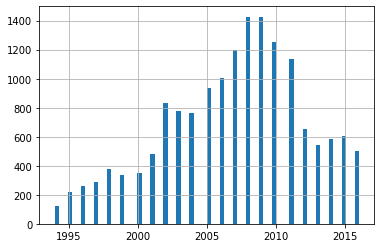

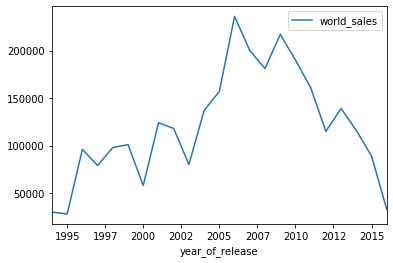

In [15]:
#2
from matplotlib.ticker import FormatStrFormatter
data_sale_platform = data_analyz.pivot_table(index = ['platform','year_of_release'],values = 'world_sales',aggfunc = 'sum').reset_index()
display(data_sale_platform)
data_analyz['year_of_release'].hist(bins = 70)
s= data_sale_platform.pivot_table(index = 'year_of_release',values = 'world_sales',aggfunc = 'sum').reset_index().plot(x = 'year_of_release', y = 'world_sales')
s.xaxis.set_major_formatter(FormatStrFormatter('%d'))
top_platform = data_sale_platform.pivot_table(index = 'platform',values = 'world_sales',aggfunc = 'sum').reset_index().sort_values(by ='world_sales',ascending = False).head(10)
top_platform.head(10)

***Вывод*** 

Количество релизов и продаж по всем платформам падает, пик был с 2007 по 2010 года. Правда более ранние релизы могут показывать меньшие продажи, потому что например игру с релизом в 2007 года покупали уже много лет,в тоже время современные игры покупают меньше по-времени.
в топ-10 продаж по платформам входит:
PS2,
X360,
PS3,
Wii,
DS,
PS,
PS4,
GBA,
PSP,
3DS


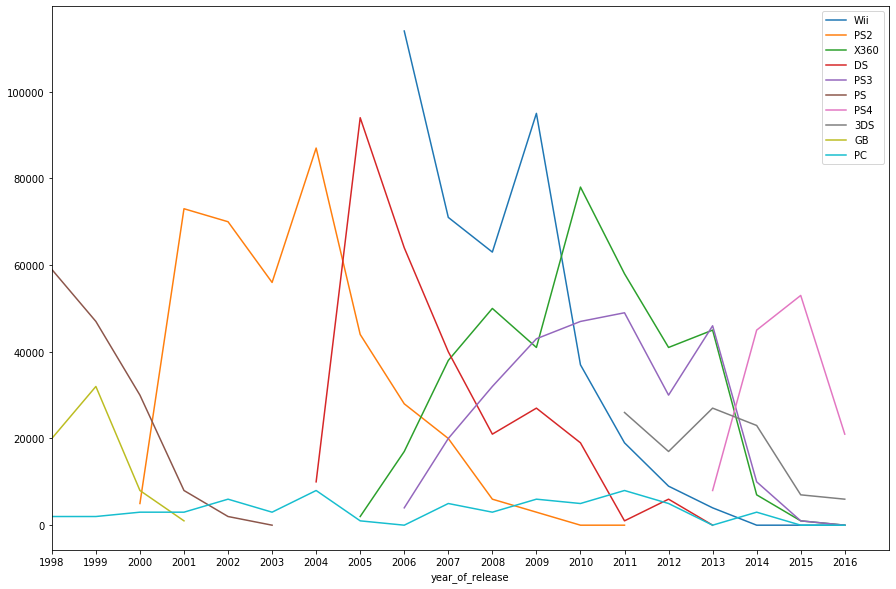

In [16]:
sd =top_platform['platform']
fig, ax = plt.subplots(figsize =(15,10))
for s in sd:
    data_sale_platform[data_sale_platform['platform'] == s].plot(x = 'year_of_release', y = 'world_sales', ax=ax)

ax.legend(sd)
ax.set_xlim([1998,2017])
ax.set_xticks(np.arange(1998,2017))
ax.set_xticklabels(range(1998,2017))
plt.show()


***Вывод*** 

Жизненный цикл у плафторм составляет 9-11 лет,топовыми платформами были пс2 и ви. Перспективными пс4, 3ds они относительно "свежие" и уже с высокими продажами.

Сейчас лидируют по продажам пс4 и 3дс. Падают все платформы,но на "закате" как раз пс3,360,ви


**Выберим несколько потенциально прибыльных платформ.**

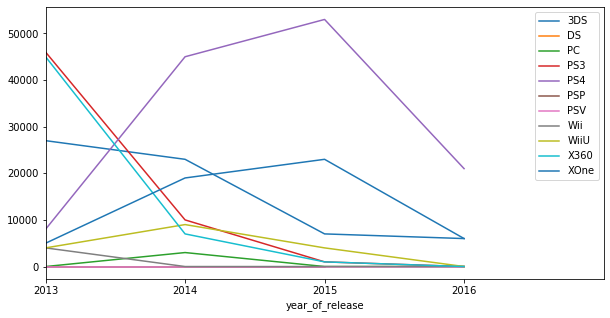

In [17]:
data_perspectiv = data_sale_platform.query('year_of_release > 2012')# посмотрим по тем платформам, где есть относительно свежие релизы
#data_perspectiv.pivot_table(index = ['platform','year_of_release'],values = 'world_sales',aggfunc = 'sum').sort_values(by = 'world_sales',ascending = False)
sc = data_perspectiv['platform'].unique()

fig, ax = plt.subplots(figsize =(10,5))
for s in sc:
    data_perspectiv[data_perspectiv['platform'] == s].plot(x = 'year_of_release', y = 'world_sales', ax=ax)
    
ax.legend(sc)
ax.set_xlim([2013,2017])
ax.set_xticks(np.arange(2013,2017))
ax.set_xticklabels(range(2013,2017))
plt.show()

***Вывод*** 

Среди перспективных платформ можно выделить пс4 однозначно,xone как конкурент свежей пс4.

3ds и wiiu они тоже свежие мобильные платформы.

на 360 и пс3 нет релизов уже,но сами продажи на них высокие, так что можно и на них игры еще продавать старые


Задания составлены так, что мне волей не волей приходилось анализировать данные за более ранние пероды,дальше буду работать с данными от 2013 года, периоды раньше учитывать не буду

In [18]:
#сделаю срез данных по актуальным для анализа играм
data_for_analyz = data.query('year_of_release > 2012')


**Сопоставим выводы с продажами игр на других платформах.**

**Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

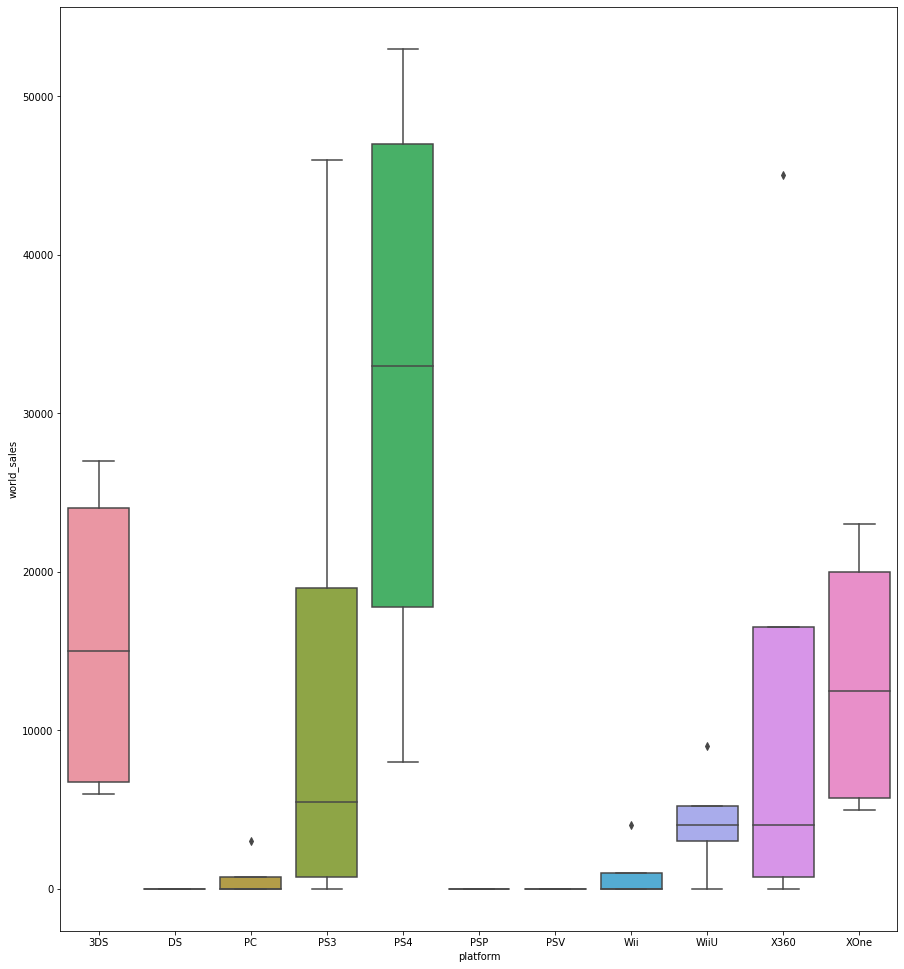

In [19]:
fig, ax = plt.subplots(figsize =(15,17))

sns.boxplot(y = 'world_sales',x = 'platform', data = data_perspectiv,ax=ax)

Почти все значения укалдываются в ящик и усы(в полтора межквартильных размаха), т.е. можно сказать,что все данные распределены нормально, те популрные платформы, которые я выделил выше в них же и самые большие разбросы(усы)

У Пс4 самая высокая медиана, на втором месте xone,на третьем 3Ds, у 360 и пс3 усы уже стремяться ближе к нулю(что показывает об их упадке)

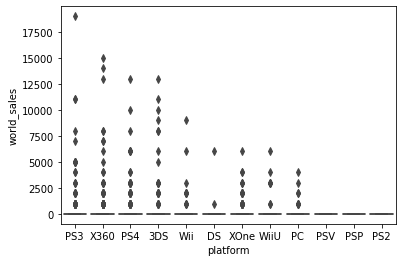

In [20]:

sns.boxplot(y = 'world_sales',x = 'platform', data = data[data['year_of_release'] >= 2011]);


***Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. ***

***Сопоставим выводы с продажами игр на других платформах.***

Вощьмем для примера пс4, как самую перспективную и популярную на данный момент консоль


-0.05046786049935478

0.3119189973509533

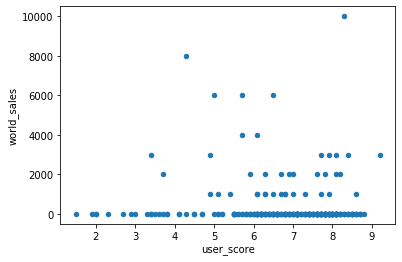

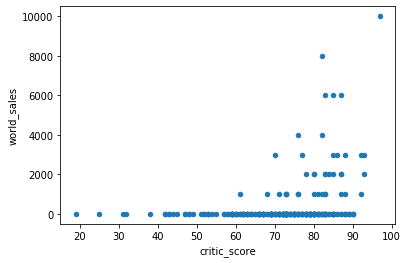

In [21]:
ps4_data_for_analyz = data_for_analyz[data_for_analyz['platform'] == 'PS4']
ps4_data_for_analyz.plot(kind = 'scatter', y = 'world_sales', x = 'user_score')
ps4_data_for_analyz.plot(kind = 'scatter', y = 'world_sales', x = 'critic_score')
display(ps4_data_for_analyz['world_sales'].corr(ps4_data_for_analyz['user_score']))
display(ps4_data_for_analyz['world_sales'].corr(ps4_data_for_analyz['critic_score']))

***Вывод:***  

Чем выше и пользовательская оценка и оценка критиков тем больше продажи, те у кого ниже 3 оценка пользователя и 60 критиков, продажи почти нулевые, и соотвественно для более высоких оценок наблюдается более высокие прдажи. Коэф-т корреляции говорит что есть слабая связь между продажами и оценками критиков(0,32)

Ниже посмотрим по всем данным с 2013 года

-0.016272087355232466

0.2214919283814961

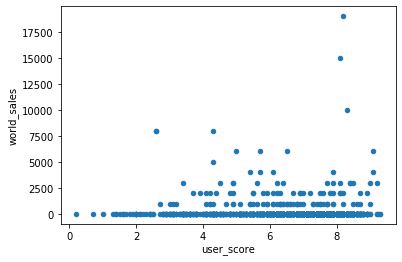

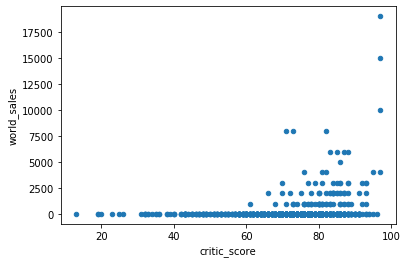

In [22]:
data_for_analyz.plot(kind = 'scatter', y = 'world_sales', x = 'user_score')
data_for_analyz.plot(kind = 'scatter', y = 'world_sales', x = 'critic_score')
display(data_for_analyz['world_sales'].corr(data_for_analyz['user_score']))
display(data_for_analyz['world_sales'].corr(data_for_analyz['critic_score']))

***Вывод:*** 

Целиком по всем платформам получилось точно такая же картина,чем выше оценка тем выше шанс заработать больше денег на играх. На низких оценках шансов что либо заработать практически нет. КОэффициент корреляции даже стал ниже по оценкам критиков.

***Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?***

In [23]:
ps = data_for_analyz.pivot_table(index = 'genre',values = 'world_sales',aggfunc=['mean','count'])
ps.columns = ['mean','count']
display(ps.sort_values(by = 'mean',ascending = False))


,mean,count
genre,,
Shooter,582.887701,187
Sports,275.700935,214
Role-Playing,181.506849,292
Fighting,137.500000,80
Action,134.464752,766
Racing,129.411765,85
Simulation,129.032258,62
Misc,109.677419,155
Platform,81.081081,74


***Вывод: ***

Самыми прибыльными жанрами можно назвать стрелялки, спорт,рпг. Самые популярные: эти же три и Экшены. Удивительно что выпушено очень много приключенческих игр а продажи оп ним ноль. ВОобще чтобы было ноль продаж это надо очень поставрарться, поэтому я делаю вывод,что скорее всего в этой бд, есть какие то ошибки в продажах.

Самые непопулярные жанры: стратегии, пазлы, платформы(по ним и самые низкие продажи)

##  Портрет пользователя каждого региона

***Определим потрерт для пользователя каждого региона (NA, EU, JP):***

***Самые популярные платформы (топ-5). Опишем различия в долях продаж.***


Выделим три отдельных дата сета для анализа по каждому регионы(чтобы в этом регионе проажи были не равны нулю).Посмотрим сначала по количеству выпускаем игр, далее по количеству продаж

In [24]:
data_for_analyz_na = data_for_analyz.query('na_sales > 0') 
data_for_analyz_eu = data_for_analyz.query('eu_sales > 0')
data_for_analyz_jp = data_for_analyz.query('jp_sales > 0')

In [25]:
display(data_for_analyz_na['platform'].value_counts().head())
display(data_for_analyz_eu['platform'].value_counts().head())
display(data_for_analyz_jp['platform'].value_counts().head())

PS4     33
XOne    26
X360    17
PS3     12
3DS      7
Name: platform, dtype: int64

PS4     36
PS3     12
XOne    10
X360     8
3DS      8
Name: platform, dtype: int64

3DS     17
WiiU     2
Name: platform, dtype: int64

По количеству выпускаемых игр 

В америке лидеры: пс4, икс бокс уан, икс бокс 360, пс 3; 

В европе: пс4,пс3,иск бокс 360, три дс и 360 одинаково

В японии: 3 дс и вию

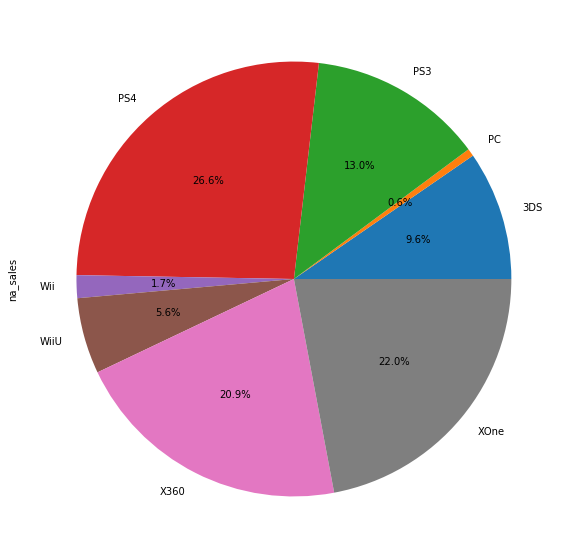

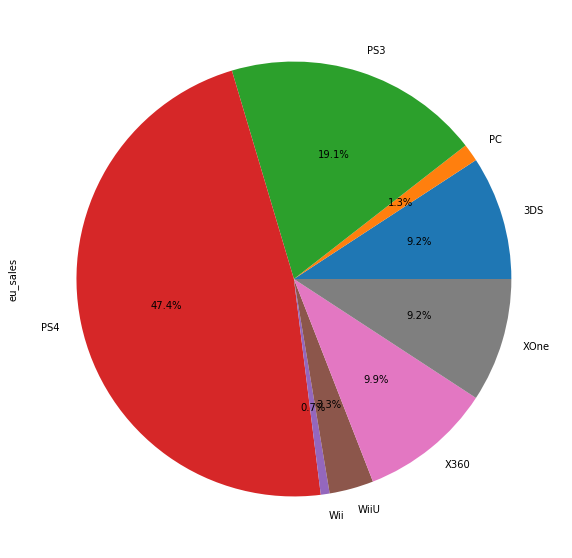

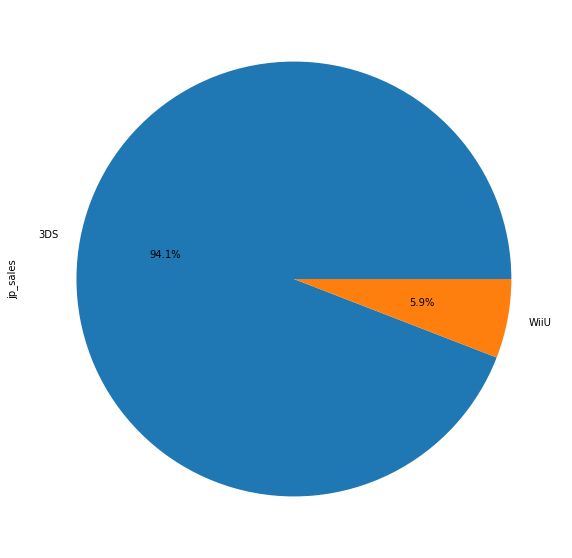

In [26]:
data_for_analyz_na.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum').plot(kind = 'pie', y = 'na_sales',figsize = (10,10),autopct='%1.1f%%',legend = False)
data_for_analyz_eu.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum').plot(kind = 'pie', y = 'eu_sales',figsize = (10,10),autopct='%1.1f%%',legend = False)
data_for_analyz_jp.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum').plot(kind = 'pie', y = 'jp_sales',figsize = (10,10),autopct='%1.1f%%',legend = False)





***Общий вывод:***

В америке существуем много платформ которые конкурируют за рынок, самые поппулярные пс4,пс3 и иксбоксы(1 и 360). ПО продажам лидирует пс4, интересно что у икс боксов новых и старых еще плюс минус похожие продажи за последние годы. По количеству выпускаемых игр и продажам данные не противоречат друг другу

В европе по продажам пс 4 и пс3 забирают почти весь рынок(66 %), на втором месте икс боксы. Игр на икс боксы тут продают меньше

В японии тотальное доминирование у 3дс


***Самые популярные жанры (топ-5).***

In [27]:
display(data_for_analyz_na['genre'].value_counts().head())
display(data_for_analyz_eu['genre'].value_counts().head())
display(data_for_analyz_jp['genre'].value_counts().head())

Shooter         34
Action          29
Sports          20
Role-Playing     6
Misc             5
Name: genre, dtype: int64

Shooter         25
Action          22
Sports          12
Role-Playing     6
Racing           5
Name: genre, dtype: int64

Role-Playing    10
Action           4
Simulation       2
Shooter          1
Racing           1
Name: genre, dtype: int64

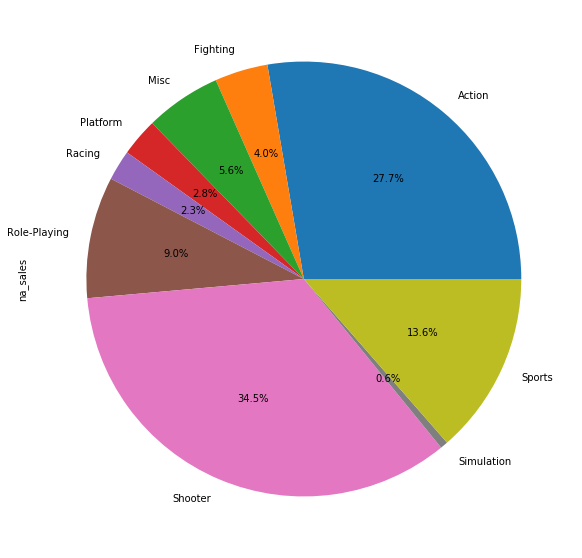

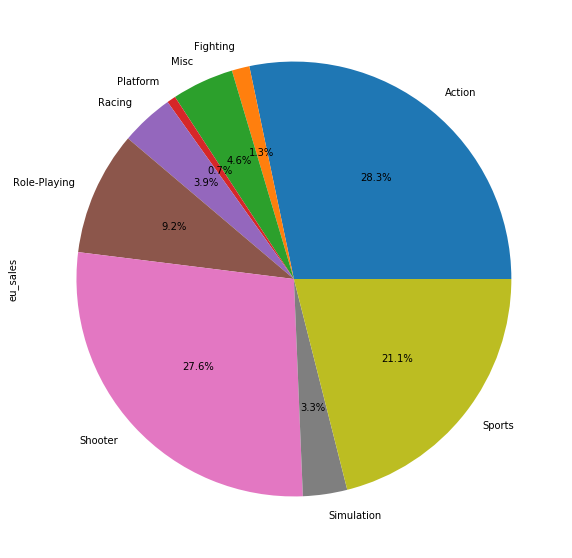

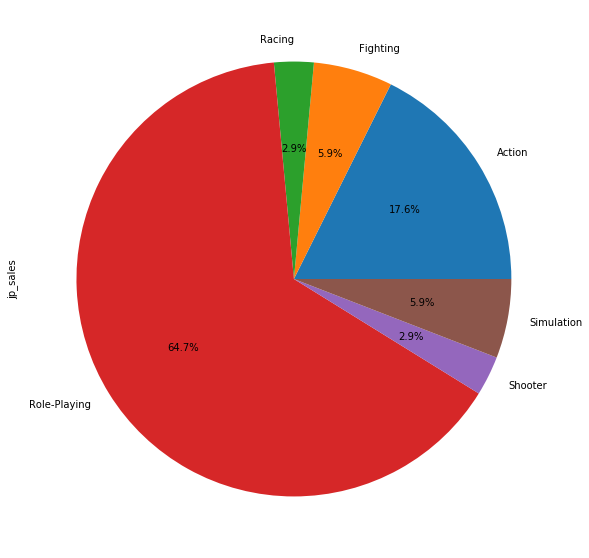

In [28]:
data_for_analyz_na.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum').plot(kind = 'pie', y = 'na_sales',figsize = (10,10),autopct='%1.1f%%',legend = False)
data_for_analyz_eu.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum').plot(kind = 'pie', y = 'eu_sales',figsize = (10,10),autopct='%1.1f%%',legend = False)
data_for_analyz_jp.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum').plot(kind = 'pie', y = 'jp_sales',figsize = (10,10),autopct='%1.1f%%',legend = False)


С точки зрения жанров, вкусы американцев и европейцев совпадают, в топ 5 и там и там входят одни и те же жанры. 

Япония можно сказать кардинально отличается по вкусам, там очень любят role-playing,на втором месте экшены,остальные жанры  там явно не доминируют.




***Влияет ли рейтинг ESRB на продажи в отдельном регионе?***

'E' - Everyone. Рассчитано на игроков от 6 лет и старше.
'M'- Mature. Игры с элементами насилия, кровью, черным юмором и крепкими выражениями. Возрастной ценз — 17 и более лет.
'T' - Teen. Реалистичное насилие и грубая лексика, но в небольших количествах. Для игроков от 13 лет.
'E10+'- Everyone 10+. Для детей от 10 лет и старше. Такие игры могут содержать элементы Cartoon Violence (мультяшной жестокости).
'K-A' - Для детей – для тех, кто уже научился говорить и держать джойстик, эти игры уже могут вызывать интерес [позже в 1998 году был переименован в Е – для всех возрастов, а также чуть позже был добавлен рейтинг Е10+, как промежуточный между Е и Т]
'AO'- Adults Only. Игры данной категории предназначены только для игроков, которым исполнилось 18 лет. Adults Only-игры содержат сцены, демонстрирующие жестокое насилие, развратное поведение, нарушения закона.
'EC' - Early Childhood. Игра разрешена детям от 3 лет и старше.
'RP' - Rating Pending. Данная иконка подтверждает, что игра уже принята на рассмотрение в ESRB, но итоговый рейтинг получить еще не успела.

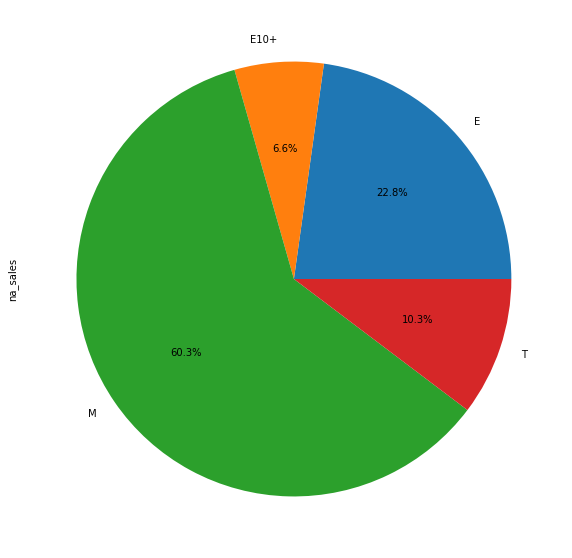

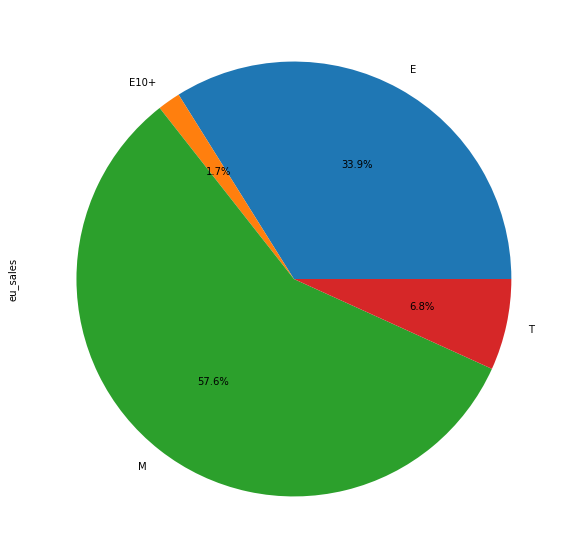

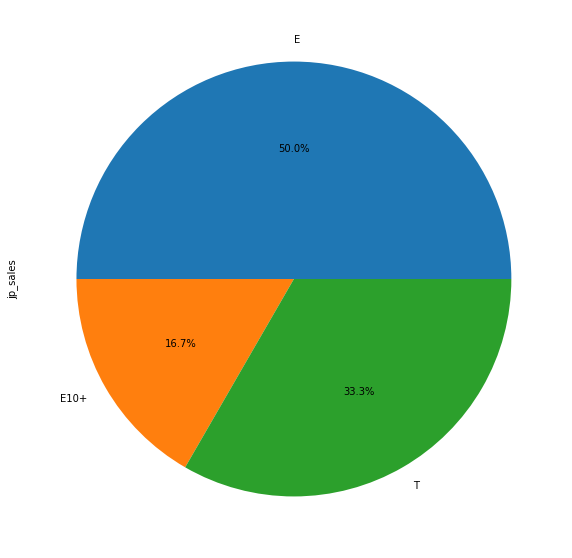

In [31]:
data_for_analyz_na.pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum').plot(kind = 'pie', y = 'na_sales',figsize = (10,10),autopct='%1.1f%%',legend = False)
data_for_analyz_eu.pivot_table(index = 'rating', values = 'eu_sales', aggfunc = 'sum').plot(kind = 'pie', y = 'eu_sales',figsize = (10,10),autopct='%1.1f%%',legend = False)
data_for_analyz_jp.pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum').plot(kind = 'pie', y = 'jp_sales',figsize = (10,10),autopct='%1.1f%%',legend = False)


***Вывод: ***

И опять вкусы американцев и европейцев почти идентичны, там очень популярны игры с жестокостью(M),остальные игры уже плюс минус детские-для каждого.

Японцы как всегда идут против всего мира в своих вкусах, там полностью доминируют детские жанры и совсем отсутвуют игры с элементами насилия.

Сказать что рейтинг как то влияет на продажи достаточно сложно, скорее по рейтингу можно понять вкусы регионов, но возможно родители при покупке игр своих детям ориентируются на данный показатель, потому что в рейтингах большая доля именно детских игр, а игр AO нет

## Проверьте гипотезы

***Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;***


Чтобы проверить данное утверждение, применим Гипотезу о равенстве средних двух генеральных совокупностей(т.к. все таки разные платформы это разные совокупности)

Сформируем нулевую гипотезу:что средние прользовательские оценки двух разных платформ равны.

Альтернативная гипотеза: что средние прользовательские оценки двух разных платформ не равны.
 

In [32]:
xone = data_for_analyz[data_for_analyz['platform']=='XOne']['user_score'].reset_index(drop= True)
pc = data_for_analyz[data_for_analyz['platform']=='PC']['user_score'].reset_index(drop= True)
xone = xone.dropna()
pc = pc.dropna()


In [33]:

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(pc, xone)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


***Вывод:***  

Средние пользовательские оценки двух платформ равны, не получилось отвергнуть нулевую гипотезу. В целом это логично потому что платформа не влияет на саму игру в целом

Сформируем нулевую гипотезу: что Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны
Альтернативную гипотезу:  что Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») не равны

In [35]:
action = data_for_analyz[data_for_analyz['genre']=='Action']['user_score'].reset_index(drop= True)
sports = data_for_analyz[data_for_analyz['genre']=='Sports']['user_score'].reset_index(drop= True)
action = action.dropna()
sports = sports.dropna()


In [36]:

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(action, sports)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Вывод: средние пользовательские оценки жанров экшн и спорт не равны, то есть их оценки отличаются у пользователей.

## Общий вывод


Если отвечать на основной вопрос, который мы ставили в начале то получается, что если мы продаем игры по всему миру то нам стоит отдельно планировать компанию для разных регионов

***Северная америка и Европа:***

Стоит сделать ставку на игры в жанре:

-Shooter  
-Action  
-Sports    
-Role-Playing  
-Misc/Racing 

В Америке на платформах(в порядке убывания) : PS4,Xone,X360-PS3,3DS,Wiiu  
В Европе: PS4,PS3,X0ne-x360,3DS,WIIu

Не самые жестокие игры в жанре M'- Mature. Игры с элементами насилия, кровью, черным юмором и крепкими выражениями. Возрастной ценз — 17 и более лет; и игры для всех без элементов насилия

***Япония***

Стоит сделать ставку на игры в жанре:

-Role-Playing  
-Action        
-Simulation      
-Shooter          
-Fighting         

На платформах: 3DS,Wiiu

Игры должны быть не жестокими! Семейные,с детскими рейтингами

  
  
Относительно платформ 360 и пс3, судя по данной базе данных, новые игры на них перестали выходить, поэтому продажи хоть и будут но по старым играм, поэтому в тренде будут пс4 и икс бокс 1. и Мобильные платформы Wiiu и 3ds
